<a href="https://colab.research.google.com/github/Datanerd97/PyTorch/blob/main/08_pytorch_transfer_learning_exercises/extras/exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 06. PyTorch Transfer Learning Exercises

Welcome to the 06. PyTorch Transfer Learning exercise template notebook.

There are several questions in this notebook and it's your goal to answer them by writing Python and PyTorch code.

> **Note:** There may be more than one solution to each of the exercises, don't worry too much about the *exact* right answer. Try to write some code that works first and then improve it if you can.

## Resources and solutions

* These exercises/solutions are based on [section 06. PyTorch Transfer Learning](https://www.learnpytorch.io/06_pytorch_transfer_learning/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.

**Solutions:**

Try to complete the code below *before* looking at these.

* See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/ueLolShyFqs).
* See an example [solutions notebook for these exercises on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/solutions/06_pytorch_transfer_learning_exercise_solutions.ipynb).

## 1. Make predictions on the entire test dataset and plot a confusion matrix for the results of our model compared to the truth labels.
* **Note:** You will need to get the dataset and the trained model/retrain the model from notebook 06 to perform predictions.
* Check out [03. PyTorch Computer Vision section 10](https://www.learnpytorch.io/03_pytorch_computer_vision/#10-making-a-confusion-matrix-for-further-prediction-evaluation) for ideas.

In [ ]:
# Import required libraries/code
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms, datasets

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Get data

In [ ]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

data/pizza_steak_sushi directory exists.


### Prepare data

In [ ]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [ ]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fe049295610>,
 ['pizza', 'steak', 'sushi'])

### Get and prepare a pretrained model

In [ ]:
# Setup the model with pretrained weights and send it to the target device
model_0 = torchvision.models.efficientnet_b0(pretrained=True).to(device)
#model_0 # uncomment to output (it's very long)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_0.features.parameters():
    param.requires_grad = False

In [ ]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

### Train model

In [ ]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

In [ ]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
model_0_results = engine.train(model=model_0,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0895 | train_acc: 0.4414 | test_loss: 0.9202 | test_acc: 0.5085
Epoch: 2 | train_loss: 0.8682 | train_acc: 0.7734 | test_loss: 0.8022 | test_acc: 0.7434
Epoch: 3 | train_loss: 0.7771 | train_acc: 0.7812 | test_loss: 0.7399 | test_acc: 0.7737
Epoch: 4 | train_loss: 0.7249 | train_acc: 0.7422 | test_loss: 0.6472 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.6445 | train_acc: 0.7812 | test_loss: 0.6244 | test_acc: 0.8968
[INFO] Total training time: 10.445 seconds


### Make predictions on the entire test dataset with the model

Solution is in 11 minutes within the model..

In [ ]:
# TODO
from tqdm.auto import tqdm

# Make predictions on the entire test dataset
test_preds = []
model_0.eval()
with torch.inference_mode():
  # Loop thorugh the batches in the test dataloader
  for X,y in tqdm(test_dataloader):
    X,y = X.to(device),y.to(device)
    # Pass the data to the model
    test_logits = model_0(X)

    # Convert the pred logits to pred probs
    pred_probs = torch.softmax(test_logits,dim = 1)

    # Convert the pred probs into pred labels
    pred_labels = torch.argmax(pred_probs,dim = 1)

    # Add the pred labels to test preds list
    test_preds.append(pred_labels)

# Concatenate the test preds and put them on the cpu..
test_preds = torch.cat(test_preds).cpu()

test_preds

  0%|          | 0/3 [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
        2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
        2, 2, 2])

### Make a confusion matrix with the test preds and the truth labels

Need the following libraries to make a confusion matrix:
* torchmetrics - https://torchmetrics.readthedocs.io/en/stable/
* mlxtend - http://rasbt.github.io/mlxtend/

In [ ]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.23.4


In [ ]:
# Import mlxtend upgraded version
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.23.4


In [ ]:
# Get the truth labels for test dataset (Get the y value from test_dataloader..)
test_truth = torch.cat([y for X,y in test_dataloader])
test_truth

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2])

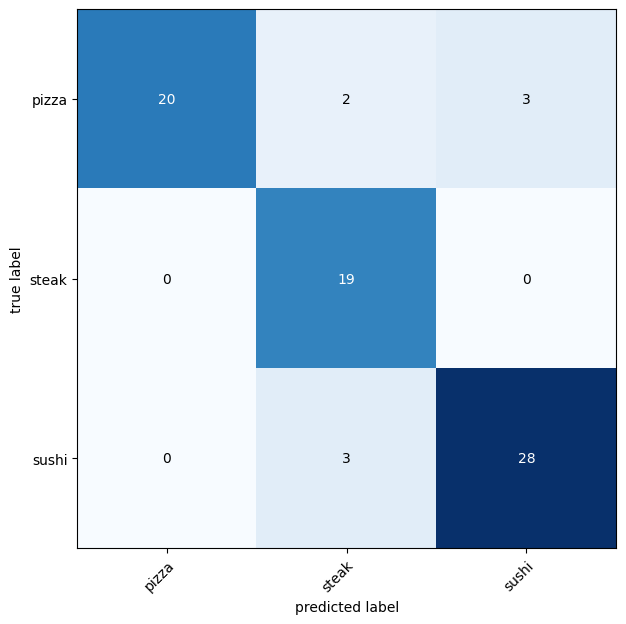

In [ ]:
# TODO
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Setup confusion instanc and compare predictions to targets
confmat = ConfusionMatrix(task = 'multiclass',num_classes = len(class_names))
confmat_tensor = confmat(preds = test_preds,
                         target = test_truth)

# Plot the confusion matrix

fig, ax = plot_confusion_matrix(
    conf_mat = confmat_tensor.numpy(),
    class_names = class_names,
    figsize = (10,7)
)

## 2. Get the "most wrong" of the predictions on the test dataset and plot the 5 "most wrong" images. You can do this by:
* Predicting across all of the test dataset, storing the labels and predicted probabilities.
* Sort the predictions by *wrong prediction* and then *descending predicted probabilities*, this will give you the wrong predictions with the *highest* prediction probabilities, in other words, the "most wrong".
* Plot the top 5 "most wrong" images, why do you think the model got these wrong?

You'll want to:
* Create a DataFrame with sample, label, prediction, pred prob
* Sort DataFrame by correct (does label == prediction)
* Sort DataFrame by pred prob (descending)
* Plot the top 5 "most wrong" image predictions

In [ ]:
# TODO (26 Minutes Within The video..)


# Get all test data paths
from pathlib import Path
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_labels = [path.parent.stem for path in test_data_paths]

# Create a function to return a list of dictionaries with sample,label,

def pred_and_store(test_paths, model, transform, class_names,device):
  test_pred_list = []
  for path in tqdm(test_paths):
    # Create empty dict to store info for each sample
    pred_dict = {}

    # Get sample path
    pred_dict["image_path"] = path

    # Get class name
    class_name = path.parent.stem
    pred_dict["class_name"] = path.parent.stem

    # Get prediction
    from PIL import Image
    img = Image.open(path) # Open Image
    transformed_image = transform(img).unsqueeze(0) # transform image and add batch dimension
    model.eval()
    with torch.inference_mode():
      pred_logit = model(transformed_image.to(device))
      pred_prob = torch.softmax(pred_logit,dim = 1)
      pred_label = torch.argmax(pred_prob,dim = 1)
      pred_class = class_names[pred_label.cpu()]

      # Make sure things in the dictionary are back on the cpu
      pred_dict["pred_prob"] = pred_prob.unsqueeze(0).max().cpu().item()
      pred_dict["pred_class"] = pred_class

    # Does the pred match the true label?
    pred_dict["correct"] = class_names == pred_class

    # Add the dictionary to the list of preds
    test_pred_list.append(pred_dict)
  return test_pred_list



test_pred_dicts = pred_and_store(test_paths = test_data_paths,
                                 model = model_0,
                                 transform = simple_transform,
                                 class_names = class_names,
                                 device = device)

test_pred_dicts

  0%|          | 0/75 [00:00<?, ?it/s]

[{'image_path': PosixPath('data/pizza_steak_sushi/test/pizza/3475871.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.45037615299224854,
  'pred_class': 'pizza',
  'correct': False},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/pizza/416067.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.7701395750045776,
  'pred_class': 'pizza',
  'correct': False},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/pizza/648055.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.44703909754753113,
  'pred_class': 'pizza',
  'correct': False},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/pizza/2019408.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.5894519090652466,
  'pred_class': 'pizza',
  'correct': False},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/pizza/2871261.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.4259094297885895,
  'pred_class': 'steak',
  'correct': False},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/pizza/2218680.jpg'),
  'class_name'

In [ ]:
# Turn the test_pred dict into a dataframe.
import pandas as pd
test_pred_df = pd.DataFrame(test_pred_dicts)

# Sort dataframe by correct them by pred_prob

test_pred_df.sort_values(by = ['correct','pred_prob'], ascending = [True,False])

top_5_most_wrong = test_pred_df.sort_values(by = ['correct','pred_prob'], ascending = [True,False]).head()

test_pred_df

,image_path,class_name,pred_prob,pred_class,correct
0,data/pizza_steak_sushi/test/pizza/3475871.jpg,pizza,0.450376,pizza,False
1,data/pizza_steak_sushi/test/pizza/416067.jpg,pizza,0.770140,pizza,False
2,data/pizza_steak_sushi/test/pizza/648055.jpg,pizza,0.447039,pizza,False
3,data/pizza_steak_sushi/test/pizza/2019408.jpg,pizza,0.589452,pizza,False
4,data/pizza_steak_sushi/test/pizza/2871261.jpg,pizza,0.425909,steak,False
...,...,...,...,...,...
70,data/pizza_steak_sushi/test/sushi/1230335.jpg,sushi,0.471797,sushi,False
71,data/pizza_steak_sushi/test/sushi/1680893.jpg,sushi,0.802827,sushi,False
72,data/pizza_steak_sushi/test/sushi/2385731.jpg,sushi,0.475265,sushi,False
73,data/pizza_steak_sushi/test/sushi/3806282.jpg,sushi,0.443208,sushi,False


<ipython-input-18-b17a00509892>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image_path = row[0]
<ipython-input-18-b17a00509892>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  true_label = row[1]
<ipython-input-18-b17a00509892>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred_prob = row[2]
<ipython-input-18-b17a00509892>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, i

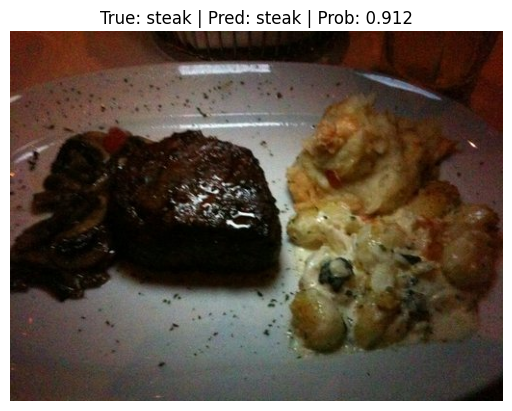

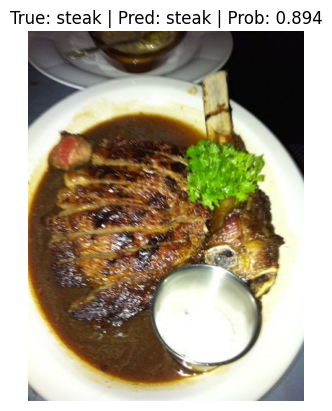

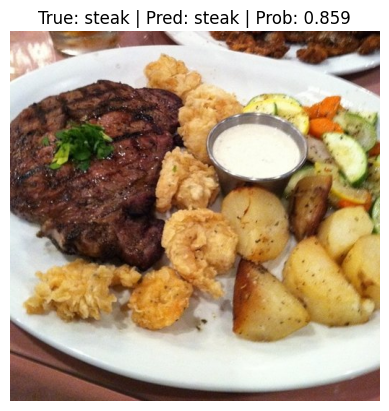

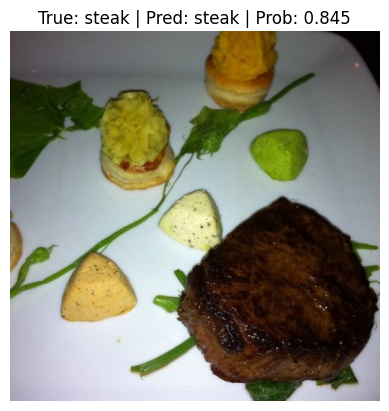

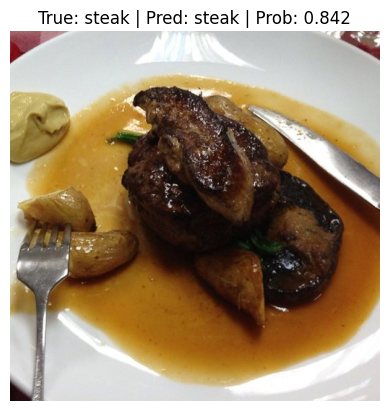

In [ ]:
import torchvision
import matplotlib.pyplot as plt

# Plot the top 5 most wrong images
for row in top_5_most_wrong.iterrows():
  row = row[1]
  image_path = row[0]
  true_label = row[1]
  pred_prob = row[2]
  pred_class = row[3]
  # Plot the image and various details
  img = torchvision.io.read_image(str(image_path)) # get images as tensor
  plt.figure()
  plt.imshow(img.permute(1,2,0))
  plt.title(f"True: {true_label} | Pred: {pred_class} | Prob: {pred_prob:.3f}")
  plt.axis(False)

## 3. Predict on your own image of pizza/steak/sushi - how does the model go? What happens if you predict on an image that isn't pizza/steak/sushi?
* Here you can get an image from a website like http://www.unsplash.com to try it out or you can upload your own.

--2025-05-03 02:13:00--  https://images.unsplash.com/photo-1571997478779-2adcbbe9ab2f
Resolving images.unsplash.com (images.unsplash.com)... 151.101.2.208, 151.101.66.208, 151.101.130.208, ...
Connecting to images.unsplash.com (images.unsplash.com)|151.101.2.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3402377 (3.2M) [image/jpeg]
Saving to: ‘photo-1571997478779-2adcbbe9ab2f.1’

photo-1571997478779 100%[===================>]   3.24M  --.-KB/s    in 0.01s   

2025-05-03 02:13:00 (247 MB/s) - ‘photo-1571997478779-2adcbbe9ab2f.1’ saved [3402377/3402377]



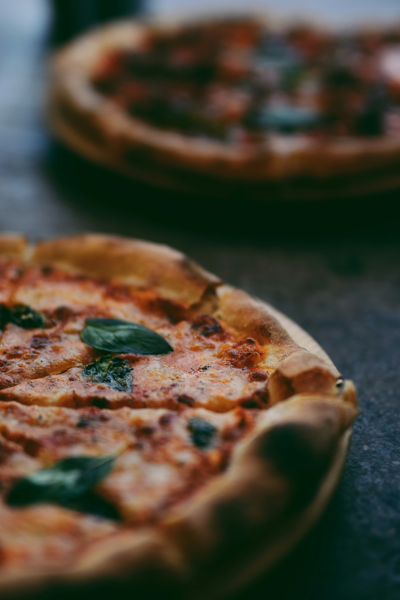

In [ ]:
# TODO: Get an image of pizza/steak/sushi
!wget https://images.unsplash.com/photo-1571997478779-2adcbbe9ab2f
!cp photo-1571997478779-2adcbbe9ab2f pizza.jpg

from PIL import Image

with Image.open("pizza.jpg") as img:
   # Reduce the image size and width by 5 (in my case)
   (width,height) = (img.width // 10, img.height // 10)
   img_resized = img.resize((width,height))

img_resized


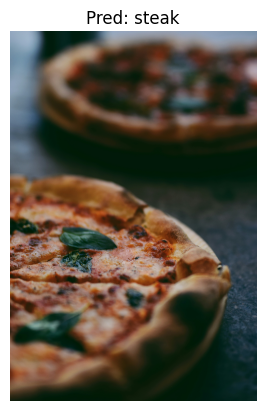

In [ ]:
# Define a function to predict and plot image..

def pred_and_plot(image_path,model,transform,class_names,device = device):
  # Open image
  image = Image.open(image_path)

  # Transform Image
  transformed_image = transform(image)

  # pred on image
  model.eval()
  with torch.inference_mode():
    pred_logit = model(transformed_image.unsqueeze(0).to(device))
    pred_label = torch.argmax(torch.softmax(pred_logit,dim = 1),dim = 1)

  # plot image and pred
  plt.figure()
  plt.imshow(image)
  plt.title(f"Pred: {class_names[pred_label]}")
  plt.axis(False)


pred_and_plot(image_path = "pizza.jpg",
              model = model_0,
              transform = simple_transform,
              class_names = class_names)

--2025-05-03 02:13:03--  https://plus.unsplash.com/premium_photo-1683619761468-b06992704398
Resolving plus.unsplash.com (plus.unsplash.com)... 151.101.2.208, 151.101.66.208, 151.101.130.208, ...
Connecting to plus.unsplash.com (plus.unsplash.com)|151.101.2.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4250749 (4.1M) [image/jpeg]
Saving to: ‘premium_photo-1683619761468-b06992704398.1’

premium_photo-16836 100%[===================>]   4.05M  --.-KB/s    in 0.07s   

2025-05-03 02:13:03 (58.1 MB/s) - ‘premium_photo-1683619761468-b06992704398.1’ saved [4250749/4250749]



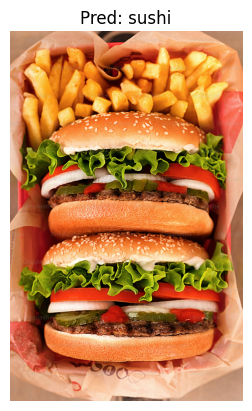

In [ ]:
# TODO: Get an image of not pizza/steak/sushi
!wget https://plus.unsplash.com/premium_photo-1683619761468-b06992704398
!cp premium_photo-1683619761468-b06992704398 burger.jpg

pred_and_plot(image_path = "burger.jpg",
              model = model_0,
              transform = simple_transform,
              class_names = class_names)

Our model is a little bit biased towards predicting sushi!

## 4. Train the model from section 4  in notebook 06 part 3 for longer (10 epochs should do), what happens to the performance?

* See the model in notebook 06 part 3 for reference: https://www.learnpytorch.io/06_pytorch_transfer_learning/#3-getting-a-pretrained-model

In [ ]:
# TODO: Recreate a new model
import torchvision
from torch import nn
model_1 = torchvision.models.efficientnet_b0(pretrained = True).to(device)

# Freeze the base layers
for param in model_1.features.parameters():
  param.requires_grad = False

# Change the classification head
model_1_classifier = torch.nn.Sequential(
    nn.Dropout(p = 0.2),
    nn.Linear(in_features = 1280, out_features = len(class_names), bias = True)
).to(device)

#summary(model_1,
               #   input_size = (32,3,224,224),
                  #col_names= ["input_size","output_size","trainable"])

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Define loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)


# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
model_1_results = engine.train(model=model_1,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 6.4611 | train_acc: 0.0078 | test_loss: 5.8428 | test_acc: 0.0104
Epoch: 2 | train_loss: 4.2232 | train_acc: 0.1367 | test_loss: 3.2009 | test_acc: 0.2273
Epoch: 3 | train_loss: 2.6993 | train_acc: 0.2500 | test_loss: 2.4293 | test_acc: 0.1970
Epoch: 4 | train_loss: 1.9405 | train_acc: 0.4531 | test_loss: 2.1614 | test_acc: 0.2983
Epoch: 5 | train_loss: 1.6586 | train_acc: 0.3711 | test_loss: 1.9507 | test_acc: 0.3513
Epoch: 6 | train_loss: 1.3619 | train_acc: 0.4297 | test_loss: 1.8589 | test_acc: 0.4233
Epoch: 7 | train_loss: 1.1942 | train_acc: 0.6562 | test_loss: 1.8227 | test_acc: 0.4650
Epoch: 8 | train_loss: 1.1681 | train_acc: 0.5430 | test_loss: 1.7658 | test_acc: 0.4953
Epoch: 9 | train_loss: 1.0339 | train_acc: 0.5820 | test_loss: 1.4826 | test_acc: 0.6705
Epoch: 10 | train_loss: 1.0071 | train_acc: 0.6094 | test_loss: 1.2213 | test_acc: 0.6903
[INFO] Total training time: 17.527 seconds


Successfully imported plot_loss_curves.


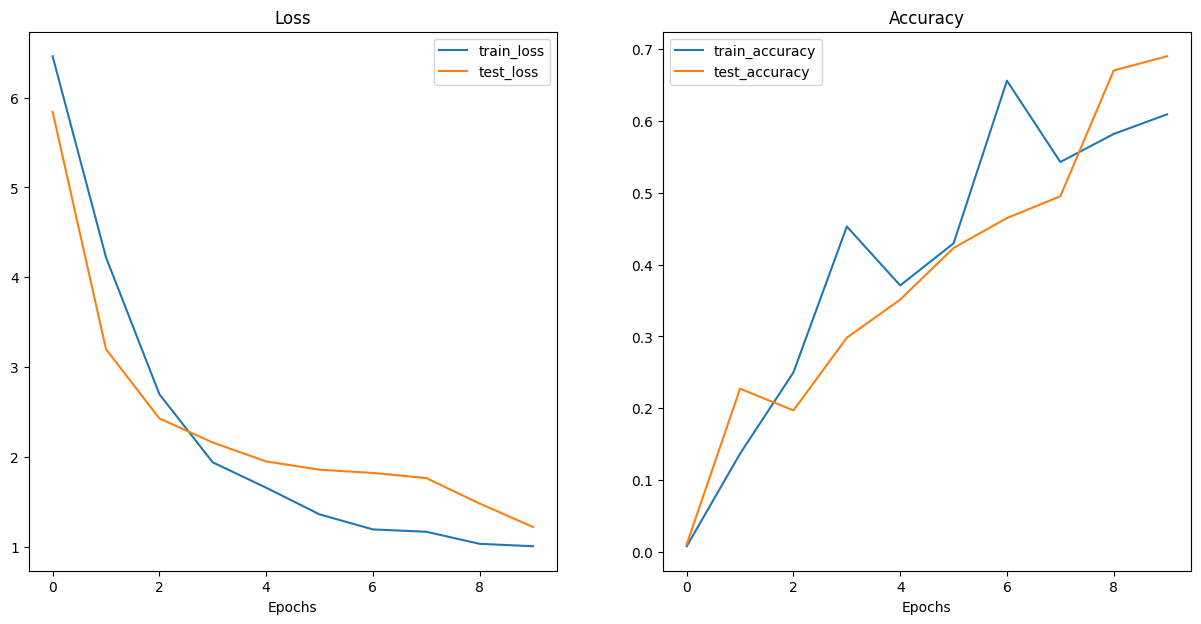

In [ ]:
try:
    from helper_functions import plot_loss_curves
    print("Successfully imported plot_loss_curves.")
except ImportError as e:
    print(f"[INFO] ImportError: {e}")
    print(f"[INFO] Couldn't find helper_functions.py, downloading...")
    import requests
    request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)
    # Try importing again after download
    from helper_functions import plot_loss_curves


# Plot the loss curves our model
plot_loss_curves(model_1_results)

If we train for longer, it looks like we get slightly lower loss and potentially higher accuracy but our model starts to look liks it overfits if we train for too long.

Potentially data augmentation or a learning decay (reduce the learning rate over time) can help to prevent overfitting.

## 5. Train the model from section 4 above with more data, say 20% of the images from Food101 of Pizza, Steak and Sushi images.
* You can find the [20% Pizza, Steak, Sushi dataset](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip) on the course GitHub. It was created with the notebook [`extras/04_custom_data_creation.ipynb`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb).


Currently on 1 hour and 33 minutes into the video (I'm so tired whew!!)

### Get 20% data

In [ ]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"
image_data_zip_path = "pizza_steak_sushi_20_percent.zip"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / image_data_zip_path, "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / image_data_zip_path, "r") as zip_ref:
        print("Unzipping pizza, steak, sushi 20% data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / image_data_zip_path)

# Setup Dirs
train_dir_20_percent = image_path / "train"
test_dir_20_percent = image_path / "test"

train_dir_20_percent, test_dir_20_percent

data/pizza_steak_sushi_20_percent directory exists.


(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

### Create DataLoaders

In [ ]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [ ]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader_20_percent, test_dataloader_20_percent, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                                     test_dir=test_dir_20_percent,
                                                                                                     transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                                                     batch_size=32) # set mini-batch size to 32

train_dataloader_20_percent, test_dataloader_20_percent, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fdfa262eb10>,
 ['pizza', 'steak', 'sushi'])

### Get a pretrained model

In [ ]:
# TODO

# Create a new model for 20 percent of the data
model_2 = torchvision.models.efficientnet_b0(pretrained=True).to(device)

# Freeze all the base layers
for param in model_2.features.parameters():
  param.requires_grad = False

# Change the classifier head
torch.manual_seed(42)
model_2.classifier = nn.Sequential(
    nn.Dropout(p = 0.2),
    nn.Linear(in_features = 1280, out_features = len(class_names),bias = True)
).to(device)

### Train a model with 20% of the data

In [ ]:
# TODO


# Define loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)


# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
model_2_results = engine.train(model=model_2,
                       train_dataloader=train_dataloader_20_percent,
                       test_dataloader=test_dataloader_20_percent,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9823 | train_acc: 0.5583 | test_loss: 0.6486 | test_acc: 0.8977
Epoch: 2 | train_loss: 0.7116 | train_acc: 0.7937 | test_loss: 0.5296 | test_acc: 0.9068
Epoch: 3 | train_loss: 0.5805 | train_acc: 0.8438 | test_loss: 0.4528 | test_acc: 0.8881
Epoch: 4 | train_loss: 0.4620 | train_acc: 0.8792 | test_loss: 0.4109 | test_acc: 0.9006
Epoch: 5 | train_loss: 0.4524 | train_acc: 0.8812 | test_loss: 0.3838 | test_acc: 0.9131
[INFO] Total training time: 15.022 seconds


In [ ]:
max(model_0_results["test_acc"]),min(model_0_results["test_loss"])

(0.8967803030303031, 0.6243551770846049)

In [ ]:
max(model_2_results["test_acc"]),min(model_2_results["test_loss"])

(0.9130681818181818, 0.3838097989559174)

## 6. Try a different model from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) on the Pizza, Steak, Sushi data, how does this model perform?
* You'll have to change the size of the classifier layer to suit our problem.
* You may want to try an EfficientNet with a higher number than our B0, perhaps `torchvision.models.efficientnet_b2()`?
  * **Note:** Depending on the model you use you will have to prepare/transform the data in a certain way.

In [ ]:
# Create a transform to transform the data
from torchvision import transforms, models

effnet_b2_transform = transforms.Compose([
    transforms.Resize((288,288)), #effnet_b2 takes images of size 288, 288
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Okay so I found the weights at the Github page

https://github.com/pytorch/vision/blob/main/torchvision/models/efficientnet.py

Go to EfficientNetB2

We have to resize our images to 228 according to the weights it is taken in.

In [ ]:
# Use 10% data sample for effnet_b2 to compare to model_0_results
train_dir,test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [ ]:
# Import the data
train_dataloader_effnet_b2, test_dataloader_effnet_b2, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                                                   test_dir = test_dir,
                                                                                                   transform = effnet_b2_transform,
                                                                                                   batch_size = 32)

In [ ]:
# TODO

# Create a effnet b2 new model https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b2.html#torchvision.models.efficientnet_b2

model_3 = torchvision.models.efficientnet_b2(pretrained = True).to(device)


# Freeze the base layers
for param in model_3.parameters():
  param.requires_grad = False


# Change the classifier head (to suit our problem)
torch.manual_seed(42)
model_3.classifier = nn.Sequential(
    nn.Dropout(p=0.3,inplace = True),
    nn.Linear(in_features = 1408,out_features = len(class_names),bias = True)
).to(device)


# Get a summary of the new model..
# Note the input size is this way.. , batched (B, C, H, W)
summary(model_3,
        input_size = [32,3,288,288],
        col_names = ["input_size","output_size","trainable"])

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                                  Input Shape               Output Shape              Trainable
EfficientNet                                            [32, 3, 288, 288]         [32, 3]                   Partial
├─Sequential: 1-1                                       [32, 3, 288, 288]         [32, 1408, 9, 9]          False
│    └─Conv2dNormActivation: 2-1                        [32, 3, 288, 288]         [32, 32, 144, 144]        False
│    │    └─Conv2d: 3-1                                 [32, 3, 288, 288]         [32, 32, 144, 144]        False
│    │    └─BatchNorm2d: 3-2                            [32, 32, 144, 144]        [32, 32, 144, 144]        False
│    │    └─SiLU: 3-3                                   [32, 32, 144, 144]        [32, 32, 144, 144]        --
│    └─Sequential: 2-2                                  [32, 32, 144, 144]        [32, 16, 144, 144]        False
│    │    └─MBConv: 3-4                                 [32, 32, 144, 144]        [32

Make sure you double check the last layer to see how it works... the # of in_features and the # of out_features

  (avgpool): AdaptiveAvgPool2d(output_size=1)
  (classifier): Sequential(
    (0): Dropout(p=0.3, inplace=True)
    (1): Linear(in_features=1408, out_features=1000, bias=True)
  )
)

In [ ]:
#summary(model_0,
       # input_size = [32,3,224,224],
       # col_names = ["input_size","output_size","trainable"])

Which one did the best?

Experiments:

* model_0 = 10% data,effnet_b0
* model_1 = 10% data,effnet_b0, 10 epochs (double training time)
* model_2 = 20% data,effnet_b0, 5 epochs (double data)
* model_3 = 10% data,effnet_b2, 4 epochs (double model parameters)

In [ ]:
# Define loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.001)


# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
model_3_results = engine.train(model=model_3,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1152 | train_acc: 0.3359 | test_loss: 0.9501 | test_acc: 0.6809
Epoch: 2 | train_loss: 0.8991 | train_acc: 0.6602 | test_loss: 0.8787 | test_acc: 0.7737
Epoch: 3 | train_loss: 0.8031 | train_acc: 0.7930 | test_loss: 0.8088 | test_acc: 0.8248
Epoch: 4 | train_loss: 0.7652 | train_acc: 0.7305 | test_loss: 0.7099 | test_acc: 0.9072
Epoch: 5 | train_loss: 0.6519 | train_acc: 0.8008 | test_loss: 0.7030 | test_acc: 0.8561
[INFO] Total training time: 9.485 seconds


In [ ]:
max(model_0_results["test_acc"]),min(model_0_results["test_loss"])

(0.8967803030303031, 0.6243551770846049)

In [ ]:
max(model_1_results["test_acc"]),min(model_1_results["test_loss"])

(0.6903409090909092, 1.2212666273117065)

In [ ]:
max(model_2_results["test_acc"]),min(model_2_results["test_loss"])

(0.9130681818181818, 0.3838097989559174)

In [ ]:
max(model_3_results["test_acc"]),min(model_3_results["test_loss"])

(0.9071969696969697, 0.7029507954915365)